# ref
# https://github.com/rdkit/UGM_2017

In [1]:
from __future__ import print_function
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
import copy
import numpy as np

In [2]:
import pandas as pd
csvfile = './data/heterocycle_reactions.csv'

Read all the patterns into RDKit reactions

In [3]:
import csv
smarts_reader = csv.DictReader(open(csvfile))
REACTIONS = []
for row in smarts_reader:
    smarts = row['SMARTS']
    if not smarts:
        continue

    for product in row['CONVERT_TO'].split(','):
        reaction = smarts + '>>' + product
        REACTIONS.append(AllChem.ReactionFromSmarts(reaction))

In [4]:
def get_unique_products(mol):
    unique = set()
    for rxn in REACTIONS:
        for newmol in rxn.RunReactants((mol,)):
            isosmi = Chem.MolToSmiles(newmol[0], isomericSmiles=True)
            if isosmi in unique:
                continue
            unique.add(isosmi)
            Chem.SanitizeMol(newmol[0])
            yield newmol[0]

In [5]:
def enumerate_heterocycles(mol):
    start = mol
    starting_points = [start]
    seen = set()
    while starting_points:
        for newmol in get_unique_products(starting_points.pop()):
            newmol_smiles = Chem.MolToSmiles(newmol)
            if newmol_smiles in seen:
                continue
            starting_points.append(newmol)
            seen.add(newmol_smiles)
            yield newmol

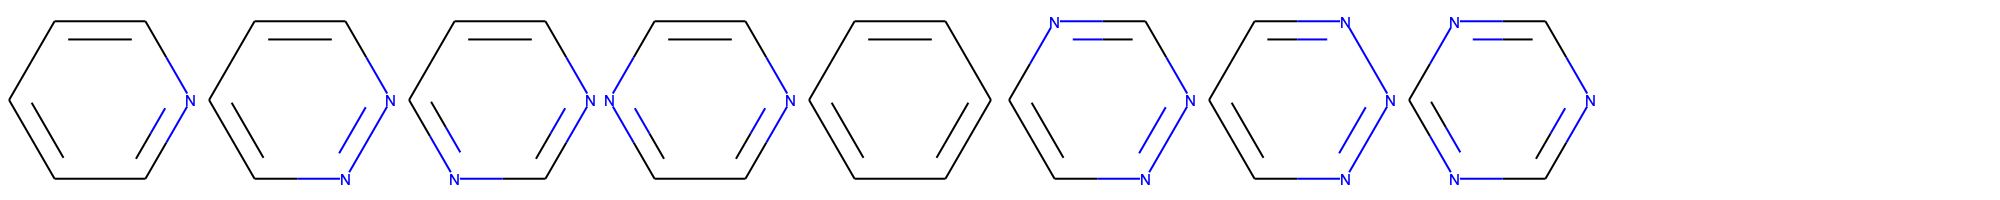

In [6]:
bnzn = Chem.MolFromSmiles('c1ccccc1')
Draw.MolsToGridImage(list(enumerate_heterocycles(bnzn)), molsPerRow=10)

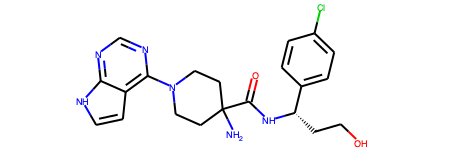

In [7]:
capivasertib = Chem.MolFromSmiles('c1cc(ccc1[C@H](CCO)NC(=O)C2(CCN(CC2)c3c4cc[nH]c4ncn3)N)Cl')
capivasertib

In [8]:
protected_capivasertib = copy.deepcopy(capivasertib)
atoms = protected_capivasertib.GetAtoms()
phenyl = Chem.MolFromSmiles('c1ccccc1')
mactches = protected_capivasertib.GetSubstructMatches(phenyl)
arr = np.array(mactches)
matches = arr.flatten()

In [9]:
for atom in atoms:
    if atom.GetIdx() not in matches:
        atom.SetProp('_protected', '1')

In [10]:
enume1 = list(enumerate_heterocycles(capivasertib))

In [11]:
enume2 = list(enumerate_heterocycles(protected_capivasertib))

In [12]:
print(len(enume1), len(enume2))

2592 9


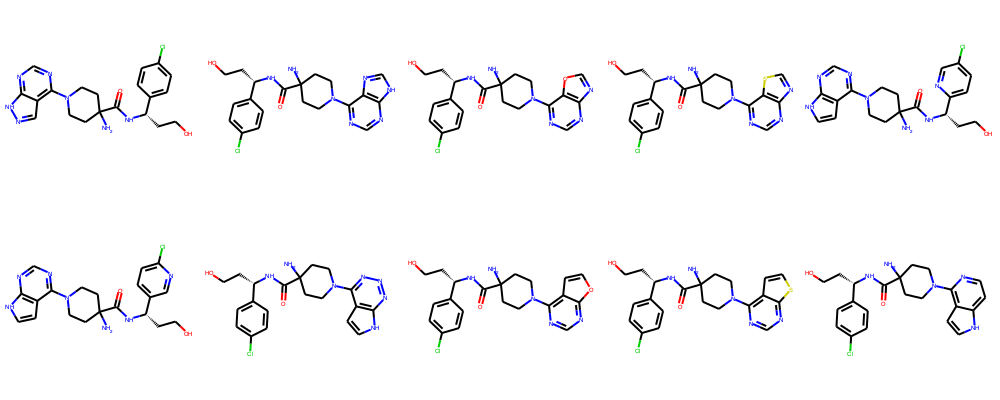

In [13]:
Draw.MolsToGridImage(enume1[:10], molsPerRow=5)

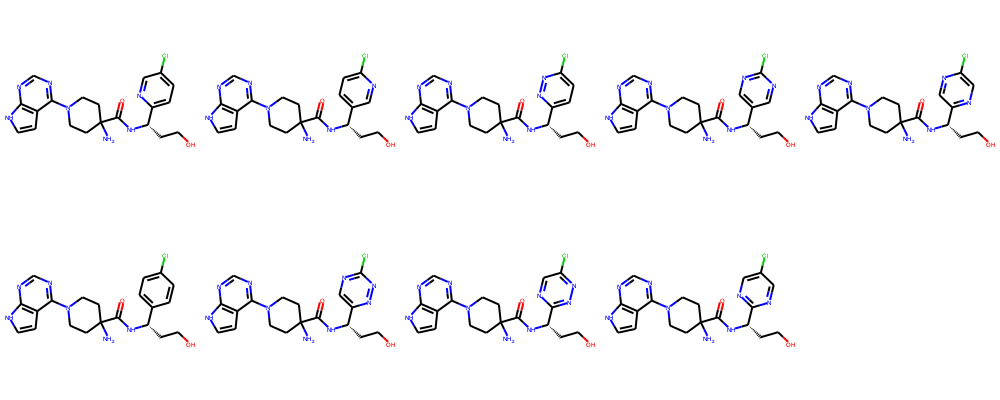

In [14]:
Draw.MolsToGridImage(enume2[:10], molsPerRow=5)